In [7]:
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
sns.set(style="whitegrid")

# linguistic
import string
import nltk
from nltk.tokenize import word_tokenize, wordpunct_tokenize, sent_tokenize

# text feature extraction
from helper import TextFeatures, CoreNLPHelper
import importlib
importlib.reload(TextFeatures)
importlib.reload(CoreNLPHelper)
coreNLPfeatures = CoreNLPHelper.CoreNLPFeatures(core_nlp_server_url="http://localhost:9000")

# svm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

#setup
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_colwidth', 100)



FOLDER_MEDIUM = os.path.join("..", "datasets", "almost_scientific_medium")
FOLDER_REPORTS = os.path.join("..", "datasets", "almost_scientific_reports")
FOLDER_ARXIV = os.path.join("..", "datasets", "scientific_arxiv")

FOLDER_TF_SCI = os.path.join("..", "..", "datasets", "tensorflow scientific papers")

# might need:
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('universal_tagset')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/arthur/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /Users/arthur/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/arthur/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

# Data gathering

In [2]:
num_samples = 2000

sent_medium = pickle.load(open(os.path.join(FOLDER_MEDIUM, "sentences.pickle"), "rb"))
sent_tf_cleaned = pickle.load(open(os.path.join(FOLDER_TF_SCI, "filtered_sent_cola.pkl"), "rb"))

# selecting sentences
random.shuffle(sent_medium)
random.shuffle(sent_tf_cleaned)
sent_medium = sent_medium[:num_samples]
sent_tf_cleaned = sent_tf_cleaned[:num_samples]

df_medium = pd.DataFrame(data=sent_medium, columns=["sentence"])
df_medium['scientific'] = 0
df_tf_cleaned = pd.DataFrame(data=sent_tf_cleaned, columns=["sentence"])
df_tf_cleaned['scientific'] = 1

df = pd.concat([df_medium, df_tf_cleaned], ignore_index=True)
print(f"df: {df.shape}")

df: (4000, 2)


# Feature extraction

In [3]:
def add_features(df, trigram_vectorizer=None):
    columns = {}

    print("lexical features character based")
    (cols_lexical_char, df_sub) = TextFeatures.extract_lexical_features_character_based(df["sentence"])
    df[cols_lexical_char] = df_sub[cols_lexical_char]
    columns["cols_lexical_char"] = cols_lexical_char

    print("lexical features word based")
    (cols_lexical_word, df_sub) = TextFeatures.extract_lexical_features_word_based(df["sentence"])
    df[cols_lexical_word] = df_sub[cols_lexical_word]
    columns["cols_lexical_word"] = cols_lexical_word
    
    print("lexical features vocabulary richness")
    (cols_vocab_rich, df_sub) = TextFeatures.extract_vocabulary_richness(df["sentence"])
    df[cols_vocab_rich] = df_sub[cols_vocab_rich]
    columns["cols_vocab_rich"] = cols_vocab_rich

    print("pos tags")
    (cols_pos_tag, df_sub) = TextFeatures.extract_pos_tags(df["sentence"], universal=False)
    df[cols_pos_tag] = df_sub[cols_pos_tag]
    columns["cols_pos_tag"] = cols_pos_tag

    print("passive sentence")
    (cols_passive, df_sub) = coreNLPfeatures.extract_passive_case(df["sentence"])
    df[cols_passive] = df_sub[cols_passive]
    columns["cols_passive"] = cols_passive
    
    print("char trigrams")
    (cols_trigram, df_sub, vec) = TextFeatures.extract_char_trigrams(df["sentence"], trigram_vectorizer)
    df[cols_trigram] = df_sub[cols_trigram]
    columns["char_trigrams"] = cols_trigram
    
    return (df, columns, vec)

In [4]:
(df, df_cols, trigram_vectorizer) = add_features(df)

lexical features character based
lexical features word based


  0%|          | 0/4000 [00:00<?, ?it/s]

lexical features vocabulary richness
pos tags


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

passive sentence


  0%|          | 0/4000 [00:00<?, ?it/s]

char trigrams
create new vectorizer


  0%|          | 0/4000 [00:00<?, ?it/s]

In [5]:
df.shape

(4000, 311)

In [6]:
df.head(2)

,sentence,scientific,total_chars,freq_chars_alpha,freq_chars_upper,freq_chars_digit,freq_chars_space,freq_chars_special,total_words,freq_words_short,avg_word_length,freq_unique_words,vocab_richness_hapax_legomena,vocab_richness_hapax_dislegomena,$,'',(,),",",--,.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,``,#,is_passive,/ a /,/ al/,/ an/,/ ar/,/ as/,/ be/,/ ca/,/ ch/,/ co/,/ da/,/ de/,/ di/,/ do/,/ ex/,/ fi/,/ fo/,/ fr/,/ ha/,/ in/,/ is/,/ it/,/ le/,/ li/,/ ma/,/ me/,/ mo/,/ ne/,/ no/,/ of/,/ on/,/ or/,/ ou/,/ pa/,/ po/,/ pr/,/ re/,/ se/,/ si/,/ so/,/ st/,/ su/,/ th/,/ to/,/ tr/,/ us/,/ we/,/ wh/,/ wi/,/ wo/,/ yo/,"/, a/","/, t/","/, w/",/a s/,/abl/,/ach/,/act/,/age/,/ain/,/al /,/all/,/an /,/and/,/ant/,/app/,/are/,/as /,/ase/,/at /,/ata/,/ate/,/ati/,/ave/,/be /,/ble/,/by /,/cal/,/can/,/ce /,/ces/,/ch /,/com/,/con/,/cti/,/d a/,/d i/,/d t/,/dat/,/del/,/der/,/e a/,/e b/,/e c/,/e d/,/e e/,/e f/,/e i/,/e l/,/e m/,/e n/,/e o/,/e p/,/e r/,/e s/,/e t/,/e w/,"/e, /",/ear/,/ect/,/ed /,/en /,/enc/,/ent/,/er /,/era/,/ere/,/ers/,/es /,/ese/,/ess/,/est/,/eve/,/f t/,/for/,/g t/,/ge /,/hat/,/hav/,/he /,/her/,/his/,/how/,/ic /,/ica/,/ide/,/ill/,/in /,/ine/,/ing/,/int/,/ion/,/is /,/ist/,/it /,/ith/,/iti/,/ity/,/ive/,/le /,/lin/,/ll /,/low/,/ly /,/mat/,/me /,/men/,/mod/,/mpl/,/n a/,/n i/,/n o/,/n t/,/nal/,/nce/,/nd /,/ne /,/ng /,/not/,/ns /,/nt /,/nte/,/nti/,/o t/,/ode/,/of /,/om /,/omp/,/on /,/one/,/ons/,/or /,/ore/,/orm/,/ot /,/our/,/ove/,/ow /,/par/,/per/,/ple/,/pre/,/pro/,/r t/,/rat/,/re /,/rea/,/red/,/res/,/rs /,/s a/,/s c/,/s f/,/s i/,/s o/,/s s/,/s t/,/s w/,"/s, /",/se /,/sed/,/sin/,/ssi/,/st /,/sta/,/ste/,/sti/,/str/,/t a/,/t i/,/t o/,/t t/,/tat/,/te /,/ted/,/ter/,/th /,/tha/,/the/,/thi/,/tic/,/tin/,/tio/,/tiv/,/to /,/tra/,/tri/,/ts /,/tur/,/ty /,/ur /,/ure/,/use/,/ut /,/ve /,/ver/,/we /,/wit/,/wor/,/y t/,/you/
0,"The set of all possible outcomes, in this case, 1, 2, 3, 4, 5, 6 is called a sample space.",0,90,0.633333,0.011111,0.066667,0.211111,0.088889,20,0.650000,3.150000,1.0,1.0,0.0,0,0,0,0,7,0,1,0,0,6,4,0,0,2,1,0,0,0,0,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0.108400,0.141107,0.0,0.0,0.0,0.0,0.267534,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092065,0.108602,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.093688,0.0,0.000000,0.176807,0.0,0.161387,0.0,0.000000,0.136589,0.0,0.0,0.0,0.0,0.062417,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.168638,0.0,0.0,0.0,0.0,0.0,0.0,0.274461,0.0,0.0,0.0,0.0,0.0,0.0,0.168236,0.0,0.000000,0.000000,0.0,0.0,0.0,0.152363,0.000000,0.159559,0.0,0.0,0.0,0.000000,0.142204,0.0,0.000000,0.159784,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.13116,0.0,0.0,0.24277,0.0,0.0,0.160694,0.000000,0.0,0.095086,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.06915,0.000000,0.131992,0.0,0.0,0.0,0.0,0.0,0.10608,0.0,0.0,0.0,0.000000,0.184363,0.0,0.0,0.0,0.0,0.0,0.0,0.272613,0.0,0.144974,0.0,0.0,0.0,0.0,0.00000,0.0,0.161503,0.0,0.0,0.0,0.115808,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.094595,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.161271,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.335146,0.0,0.000000,0.000000,0.0,0.0,0.0,0.151496,0.0,0.0,0.0,0.177445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.161972,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.063306,0.126959,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"There is a data_range function, which returns dates incremented by days, months or years, etc.",0,94,0.797872,0.010638,0.000000,0.148936,0.053191,15,0.333333,5.066667,1.0,1.0,0.0,0,0,0,0,3,0,1,0,1,0,1,1,1,1,0,0,0,0,0,2,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,1,0,0,0,0,0,0,0.104786,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.458867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.088996,0.104981,0.0,0.0,0.0,0.0,0.0,0.136178,0.0,0.0,0.000000,0.0,0.170607,0.000000,0.0,0.000000,

# SVM model training

In [241]:
# (1) normalize pos tags for SVM model
df[df_cols['cols_pos_tag']] = df[df_cols['cols_pos_tag']].div(df.total_words, axis=0)
# for pos_tags only
#df[df_cols['cols_pos_tag']] = df[df_cols['cols_pos_tag']].multiply(df.total_words, axis=0)

df.head(2)

,sentence,scientific,total_chars,freq_chars_alpha,freq_chars_upper,freq_chars_digit,freq_chars_space,freq_chars_special,total_words,freq_words_short,avg_word_length,freq_unique_words,vocab_richness_hapax_legomena,vocab_richness_hapax_dislegomena,$,'',(,),",",--,.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,``,#,is_passive,/ a /,/ al/,/ an/,/ ar/,/ as/,/ be/,/ ca/,/ ch/,/ co/,/ da/,/ de/,/ di/,/ do/,/ ex/,/ fi/,/ fo/,/ fr/,/ ha/,/ in/,/ is/,/ it/,/ le/,/ li/,/ ma/,/ me/,/ mo/,/ ne/,/ no/,/ of/,/ on/,/ or/,/ ou/,/ pa/,/ po/,/ pr/,/ re/,/ se/,/ si/,/ so/,/ st/,/ su/,/ th/,/ to/,/ tr/,/ us/,/ we/,/ wh/,/ wi/,/ wo/,/ yo/,"/, a/","/, t/","/, w/",/a s/,/abl/,/ach/,/act/,/age/,/ain/,/al /,/all/,/an /,/and/,/ant/,/app/,/are/,/as /,/ase/,/at /,/ata/,/ate/,/ati/,/ave/,/be /,/ble/,/by /,/cal/,/can/,/ce /,/ces/,/ch /,/com/,/con/,/cti/,/d a/,/d i/,/d t/,/dat/,/del/,/der/,/e a/,/e b/,/e c/,/e d/,/e e/,/e f/,/e i/,/e l/,/e m/,/e n/,/e o/,/e p/,/e r/,/e s/,/e t/,/e w/,"/e, /",/ear/,/ect/,/ed /,/en /,/enc/,/ent/,/er /,/era/,/ere/,/ers/,/es /,/ese/,/ess/,/est/,/eve/,/f t/,/for/,/g t/,/ge /,/hat/,/hav/,/he /,/her/,/his/,/how/,/ic /,/ica/,/ide/,/ill/,/in /,/ine/,/ing/,/int/,/ion/,/is /,/ist/,/it /,/ith/,/iti/,/ity/,/ive/,/le /,/lin/,/ll /,/low/,/ly /,/mat/,/me /,/men/,/mod/,/mpl/,/n a/,/n i/,/n o/,/n t/,/nal/,/nce/,/nd /,/ne /,/ng /,/not/,/ns /,/nt /,/nte/,/nti/,/o t/,/ode/,/of /,/om /,/omp/,/on /,/one/,/ons/,/or /,/ore/,/orm/,/ot /,/our/,/ove/,/ow /,/par/,/per/,/ple/,/pre/,/pro/,/r t/,/rat/,/re /,/rea/,/red/,/res/,/rs /,/s a/,/s c/,/s f/,/s i/,/s o/,/s s/,/s t/,/s w/,"/s, /",/se /,/sed/,/sin/,/ssi/,/st /,/sta/,/ste/,/sti/,/str/,/t a/,/t i/,/t o/,/t t/,/tat/,/te /,/ted/,/ter/,/th /,/tha/,/the/,/thi/,/tic/,/tin/,/tio/,/tiv/,/to /,/tra/,/tri/,/ts /,/tur/,/ty /,/ur /,/ure/,/use/,/ut /,/ve /,/ver/,/we /,/wit/,/wor/,/y t/,/you/
0,"The set of all possible outcomes, in this case, 1, 2, 3, 4, 5, 6 is called a sample space.",0,90,0.633333,0.011111,0.066667,0.211111,0.088889,20,0.650000,3.150000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.35,0.0,0.050000,0.0,0.000000,0.3,0.200000,0.000000,0.000000,0.100000,0.05,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.050000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050000,0.0,0.050000,0.000000,0.0,0.0,0.0,0.0,0.0,1,0.108400,0.141107,0.0,0.0,0.0,0.0,0.267534,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092065,0.108602,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.093688,0.0,0.000000,0.176807,0.0,0.161387,0.0,0.000000,0.136589,0.0,0.0,0.0,0.0,0.062417,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.168638,0.0,0.0,0.0,0.0,0.0,0.0,0.274461,0.0,0.0,0.0,0.0,0.0,0.0,0.168236,0.0,0.000000,0.000000,0.0,0.0,0.0,0.152363,0.000000,0.159559,0.0,0.0,0.0,0.000000,0.142204,0.0,0.000000,0.159784,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.13116,0.0,0.0,0.24277,0.0,0.0,0.160694,0.000000,0.0,0.095086,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.06915,0.000000,0.131992,0.0,0.0,0.0,0.0,0.0,0.10608,0.0,0.0,0.0,0.000000,0.184363,0.0,0.0,0.0,0.0,0.0,0.0,0.272613,0.0,0.144974,0.0,0.0,0.0,0.0,0.00000,0.0,0.161503,0.0,0.0,0.0,0.115808,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.094595,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.161271,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.335146,0.0,0.000000,0.000000,0.0,0.0,0.0,0.151496,0.0,0.0,0.0,0.177445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.161972,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.063306,0.126959,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"There is a data_range function, which returns dates incremented by days, months or years, etc.",0,94,0.797872,0.010638,0.000000,0.148936,0.053191,15,0.333333,5.066667,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.20,0.0,0.066667,0.0,0.066667,0.0,0.066667,0.066667,0.066667,0.066667,0.00,0.0,0.0,0.0,0.0,0.133333,0.0,0.0,0.266667,0.

In [8]:
# (2) columns to be excluded: total and average values
total_values = [c for c in list(df.columns) if c.startswith("total_")]
total_values += [c for c in list(df.columns) if c.startswith("avg_")]
total_values

['total_chars', 'total_words', 'avg_word_length']

In [9]:
exclude_further = [c for c in list(df.columns) if c.startswith("freq_chars_")]
exclude_further += ":"
exclude_further

['freq_chars_alpha',
 'freq_chars_upper',
 'freq_chars_digit',
 'freq_chars_space',
 'freq_chars_special',
 ':']

In [72]:
df_cols.keys()

dict_keys(['cols_lexical_char', 'cols_lexical_word', 'cols_vocab_rich', 'cols_pos_tag', 'cols_passive', 'char_trigrams'])

training X: ['$', "''", '(', ')', ',', '--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``', '#']

training y: scientific

excluded: ['sentence', 'scientific', 'total_chars', 'total_words', 'avg_word_length', 'freq_chars_alpha', 'freq_chars_upper', 'freq_chars_digit', 'freq_chars_space', 'freq_chars_special', ':']


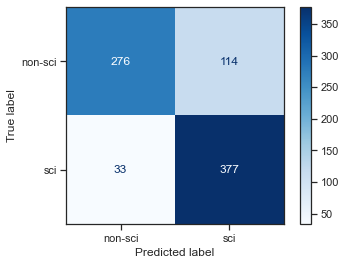

In [232]:
# phase 1 v1 plain + v2 hyperparameter tuning
#exclude_from_training = ["sentence", "scientific"] + df_cols["char_trigrams"]

# v3 no total values -> overfitted model
#exclude_from_training = ["sentence", "scientific"] + total_values + df_cols["char_trigrams"]

# v4 feature selection
#exclude_from_training = ["sentence", "scientific"] + total_values + exclude_further + df_cols["char_trigrams"]

# v5 final model: adding char trigrams
#exclude_from_training = ["sentence", "scientific"] + total_values + exclude_further

# v6 pos tags only:
#include_for_training = df_cols['cols_pos_tag']
#X = df[include_for_training]


X = df.drop(exclude_from_training, axis=1)
y = df['scientific']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

clf_svm = SVC(kernel='rbf')
clf_svm.fit(X_train, y_train)


y_pred = clf_svm.predict(X_test)
plot_confusion_matrix(clf_svm,
                             X_test,
                             y_test,
                             display_labels=["non-sci", "sci"],
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )

print(f"training X: {list(X.columns)}\n")
print(f"training y: {y.name}\n")

print(f"excluded: {exclude_from_training}")

In [233]:
print(classification_report(y_test,y_pred, target_names=["non-sci", "sci"]))

              precision    recall  f1-score   support

     non-sci       0.89      0.71      0.79       390
         sci       0.77      0.92      0.84       410

    accuracy                           0.82       800
   macro avg       0.83      0.81      0.81       800
weighted avg       0.83      0.82      0.81       800



## Hyperparameter tuning

In [234]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 2, n_jobs=2)

# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(estimator=SVC(), n_jobs=2,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=2)

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=10, gamma=0.01)


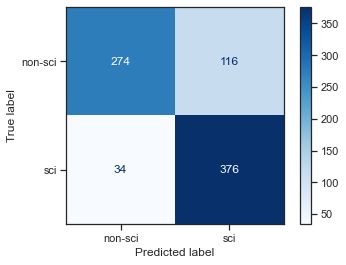

In [235]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
  
plot_confusion_matrix(grid,
                             X_test,
                             y_test,
                             display_labels=["non-sci", "sci"],
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )

In [236]:
# print classification report
print(classification_report(y_test, grid_predictions, target_names=["non-sci", "sci"]))

              precision    recall  f1-score   support

     non-sci       0.89      0.70      0.79       390
         sci       0.76      0.92      0.83       410

    accuracy                           0.81       800
   macro avg       0.83      0.81      0.81       800
weighted avg       0.83      0.81      0.81       800



# Export model

In [237]:
import joblib
export = {"model": grid.best_estimator_,
         "excluded": exclude_from_training,
         "df_train": df,
         "trigram_vectorizer": trigram_vectorizer}
joblib.dump(export, 'svm_style_classifier_v6_pos_tags_only.joblib.z') 

['svm_style_classifier_v6_pos_tags_only.joblib.z']

# Load model

In [1]:
import joblib
import_obj = joblib.load('svm_style_classifier_v4_less_char_freq.joblib.z')
svm_clf = import_obj['model']
svm_clf_df = import_obj['df_train']
svm_clf_cols_excluded = import_obj['excluded']
svm_clf_trigram_vectorizer = import_obj['trigram_vectorizer']

# Validation

## Validation with student reports

In [21]:
####
## get data, execute once
###

sent_studentreports = pickle.load(open(os.path.join(FOLDER_REPORTS, "sentences.pickle"), "rb"))
print(f"Number of sentences: {len(sent_studentreports)}")

df_val = pd.DataFrame(data=sent_studentreports, columns=["sentence"])
(df_val, columns_val_student,v) = add_features(df_val,svm_clf_trigram_vectorizer)

# normalize
df_val[columns_val_student['cols_pos_tag']] = df_val[columns_val_student['cols_pos_tag']].div(df_val.total_words, axis=0)

df_val.shape

Number of sentences: 4389
lexical features character based
lexical features word based


  0%|          | 0/4389 [00:00<?, ?it/s]

lexical features vocabulary richness
pos tags


  0%|          | 0/4389 [00:00<?, ?it/s]

  0%|          | 0/4389 [00:00<?, ?it/s]

passive sentence


  0%|          | 0/4389 [00:00<?, ?it/s]

char trigrams


  0%|          | 0/4389 [00:00<?, ?it/s]

(4389, 310)

In [224]:
df_val['scientific'] = 0
df_val.drop("pred_sci", axis=1, inplace=True)

val_pred = svm_clf.predict(df_val.drop(svm_clf_cols_excluded, axis=1))
df_val['pred_sci'] = val_pred

print(classification_report(df_val['scientific'],df_val['pred_sci'], target_names=["non-sci", "sci"]))

ValueError: X.shape[1] = 300 should be equal to 46, the number of features at training time

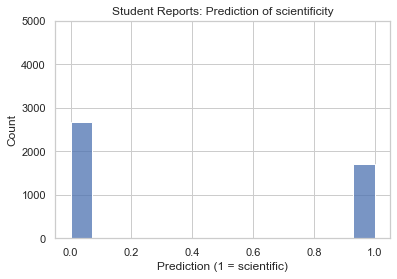

In [200]:
ax = sns.histplot(data=df_val, x="pred_sci")
ax.set_title("Student Reports: Prediction of scientificity")
ax.set_xlabel("Prediction (1 = scientific)")
ax.set_ylim((0,5000))
plt.savefig(os.path.join("plots","val_student_reports.png"), facecolor='white', dpi=300)

Much better. Majority is considered as non-scientific.

## Validation with scientific sentences from latest tf cleaned

In [24]:
####
## get data, execute once
###

# load sci dataset
sent_tf_cleaned_val = pickle.load(open(os.path.join(FOLDER_TF_SCI, "filtered_sent_cola.pkl"), "rb"))
print(f"{len(sent_tf_cleaned_val)} - original size")

# remove sentences that were used for training & testing SVM
sent_tf_cleaned_val = [s for s in sent_tf_cleaned_val if s not in sent_tf_cleaned]
print(f"{len(sent_tf_cleaned_val)} - size after filtering")

# randomize them
random.shuffle(sent_tf_cleaned_val)

# extract features
df_val_sci = pd.DataFrame(data=sent_tf_cleaned_val[:5000], columns=["sentence"])
(df_val_sci, columns_val_sci, v) = add_features(df_val_sci,svm_clf_trigram_vectorizer)

# normalize
df_val_sci[columns_val_sci['cols_pos_tag']] = df_val_sci[columns_val_sci['cols_pos_tag']].div(df_val_sci.total_words, axis=0)

df_val_sci.shape

105056 - original size
103056 - size after filtering
lexical features character based
lexical features word based


  0%|          | 0/5000 [00:00<?, ?it/s]

lexical features vocabulary richness
pos tags


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

passive sentence


  0%|          | 0/5000 [00:00<?, ?it/s]

char trigrams


  0%|          | 0/5000 [00:00<?, ?it/s]

(5000, 310)

In [172]:
# to allow for repeated execution
df_val_sci['scientific'] = 1
df_val_sci.drop("pred_sci", axis=1, inplace=True)

val_pred_sci = svm_clf.predict(df_val_sci.drop(svm_clf_cols_excluded, axis=1))
df_val_sci['pred_sci'] = val_pred_sci

print(classification_report(df_val_sci['scientific'],df_val_sci['pred_sci'], target_names=["non-sci", "sci"]))

              precision    recall  f1-score   support

     non-sci       0.00      0.00      0.00         0
         sci       1.00      0.88      0.93      5000

    accuracy                           0.88      5000
   macro avg       0.50      0.44      0.47      5000
weighted avg       1.00      0.88      0.93      5000



Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


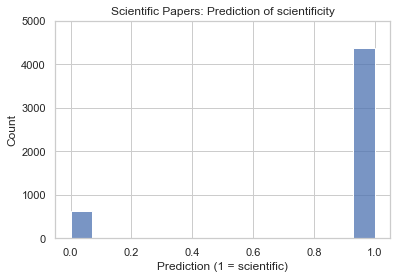

In [199]:
ax = sns.histplot(data=df_val_sci, x="pred_sci")
ax.set_title("Scientific Papers: Prediction of scientificity")
ax.set_xlabel("Prediction (1 = scientific)")
ax.set_ylim((0,5000))
plt.savefig(os.path.join("plots","val_scientific_papers.png"), facecolor='white', dpi=300)

# Analysis

## Statistics about SVM

In [2]:
svm_clf.n_support_

array([806, 843], dtype=int32)

In [3]:
# features
len([c for c in list(svm_clf_df.columns) if c not in svm_clf_cols_excluded])

50

In [4]:
print(", ".join([c for c in list(svm_clf_df.columns) if c not in svm_clf_cols_excluded]))

freq_words_short, freq_unique_words, vocab_richness_hapax_legomena, vocab_richness_hapax_dislegomena, $, '', (, ), ,, --, ., CC, CD, DT, EX, FW, IN, JJ, JJR, JJS, LS, MD, NN, NNP, NNPS, NNS, PDT, POS, PRP, PRP$, RB, RBR, RBS, RP, SYM, TO, UH, VB, VBD, VBG, VBN, VBP, VBZ, WDT, WP, WP$, WRB, ``, #, is_passive


## SHAP insights

Now we can have a look into which features are most important.

In [12]:
# https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
import shap

# The SHAP values
X = svm_clf_df.drop(svm_clf_cols_excluded, axis=1)
X_sample = shap.sample(X, nsamples=50, random_state=0)

svm_explainer = shap.KernelExplainer(svm_clf.predict,X_sample)
svm_shap_values = svm_explainer.shap_values(X_sample)

  0%|          | 0/50 [00:00<?, ?it/s]

In [46]:
# load
import_obj = joblib.load('svm_v4_shap_50samples.joblib.z')
svm_explainer = import_obj['svm_explainer']
svm_shap_values = import_obj['svm_shap_values']
X_sample = import_obj['X_sample']
X = import_obj['X']

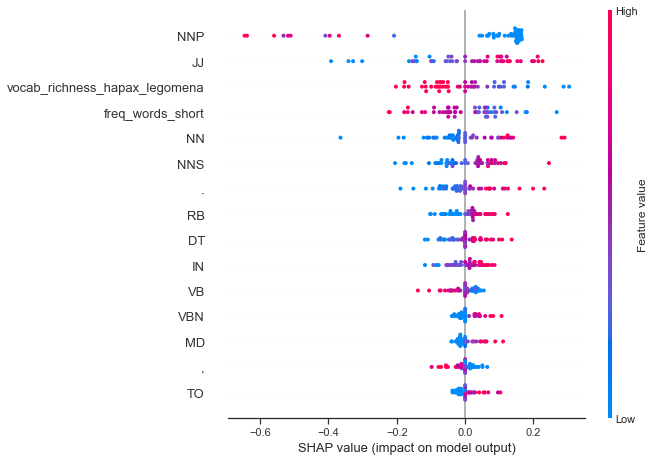

In [47]:
# export summary plot
max_display = 15

sns.set_style("ticks")
shap.summary_plot(svm_shap_values, X_sample, show=True, max_display=max_display)

export = False

if export:
    shap.summary_plot(svm_shap_values, X_sample, show=False,max_display=max_display)
    plt.title("SHAP summary plot (v4)")
    plt.tight_layout()
    plt.savefig(os.path.join("plots","shap_summary_plot_v4_50samples.png"), facecolor='white', dpi=300)
    plt.close()

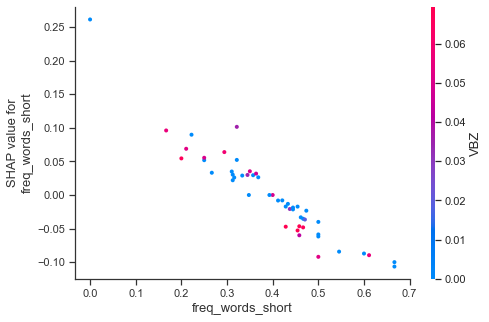

In [43]:
feature = "freq_words_short"
shap.dependence_plot(feature, svm_shap_values, X_sample)

export = True

if export:
    shap.dependence_plot(feature, svm_shap_values, X_sample, show=False)
    plt.title(f"SHAP dependency plot (v5) - {feature}")
    plt.tight_layout()
    plt.savefig(os.path.join("plots",f"shap_dependency_plot_v5_{feature.replace('/','-')}.png"), facecolor='white', dpi=300)
    plt.close()

In [210]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or